# NB03: Environmental Correlation of PHB Pathway Distribution

**Purpose**: Test whether species with PHB pathways are enriched in environments with temporally variable carbon availability (the feast/famine hypothesis).

**Requires**: BERDL JupyterHub (Spark session)

**Inputs**:
- `data/phb_by_taxonomy.tsv` from NB02

**Outputs**:
- `data/species_environment.tsv` — species-level environment classifications
- `data/phb_embedding_analysis.tsv` — AlphaEarth embedding analysis
- `figures/phb_by_environment.png` — PHB prevalence by environment type
- `figures/embedding_variance_phb.png` — Environmental breadth (embedding variance) vs PHB status

## Environmental Scoring Strategy

Three independent environment axes:
1. **NCBI labels**: isolation_source, env_broad_scale from `ncbi_env` (EAV format)
2. **AlphaEarth embeddings**: 64-dim environmental embeddings (28% genome coverage)
3. **Environment classification**: Categorize species as soil/marine/freshwater/host-associated/etc.

In [1]:
spark = get_spark_session()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

PROJECT_DIR = os.path.expanduser('~/BERIL-research-observatory/projects/phb_granule_ecology')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')

# Load NB02 results
tax_phb = pd.read_csv(os.path.join(DATA_DIR, 'phb_by_taxonomy.tsv'), sep='\t')
print(f'Loaded {len(tax_phb):,} species')

Loaded 27,690 species


## Part 1: NCBI Environment Metadata

Extract isolation_source and environmental labels for genomes, aggregate to species level.

In [2]:
# Extract environment metadata for all genomes
# ncbi_env is EAV format — pivot to get isolation_source, env_broad_scale, host
env_data = spark.sql("""
    SELECT g.genome_id, g.gtdb_species_clade_id,
           MAX(CASE WHEN ne.harmonized_name = 'isolation_source' THEN ne.content END) as isolation_source,
           MAX(CASE WHEN ne.harmonized_name = 'env_broad_scale' THEN ne.content END) as env_broad_scale,
           MAX(CASE WHEN ne.harmonized_name = 'env_local_scale' THEN ne.content END) as env_local_scale,
           MAX(CASE WHEN ne.harmonized_name = 'env_medium' THEN ne.content END) as env_medium,
           MAX(CASE WHEN ne.harmonized_name = 'host' THEN ne.content END) as host,
           MAX(CASE WHEN ne.harmonized_name = 'geo_loc_name' THEN ne.content END) as geo_loc_name
    FROM kbase_ke_pangenome.genome g
    JOIN kbase_ke_pangenome.ncbi_env ne ON g.ncbi_biosample_id = ne.accession
    GROUP BY g.genome_id, g.gtdb_species_clade_id
""").toPandas()

print(f'Genomes with environment metadata: {len(env_data):,}')
print(f'Species represented: {env_data["gtdb_species_clade_id"].nunique():,}')
print(f'\nField coverage:')
for col in ['isolation_source', 'env_broad_scale', 'env_local_scale', 'host', 'geo_loc_name']:
    n = env_data[col].notna().sum()
    print(f'  {col}: {n:,} ({n/len(env_data)*100:.1f}%)')

Genomes with environment metadata: 293,050
Species represented: 27,690

Field coverage:
  isolation_source: 245,717 (83.8%)
  env_broad_scale: 88,321 (30.1%)
  env_local_scale: 79,863 (27.3%)
  host: 170,851 (58.3%)
  geo_loc_name: 271,162 (92.5%)


In [3]:
# Classify environments into broad categories
# Based on isolation_source keywords (following env_embedding_explorer approach)

def classify_environment(row):
    """Classify genome environment from NCBI metadata."""
    source = str(row.get('isolation_source', '')).lower()
    host = str(row.get('host', '')).lower()
    env_broad = str(row.get('env_broad_scale', '')).lower()
    
    # Human/clinical
    if any(kw in source for kw in ['blood', 'sputum', 'urine', 'wound', 'clinical',
                                     'patient', 'hospital', 'human']):
        return 'human_clinical'
    if 'homo sapiens' in host or 'human' in host:
        return 'human_associated'
    
    # Animal-associated
    if any(kw in source for kw in ['animal', 'bovine', 'chicken', 'pig', 'cattle',
                                     'poultry', 'feces', 'gut', 'intestin']):
        return 'animal_associated'
    
    # Soil/rhizosphere
    if any(kw in source for kw in ['soil', 'rhizosphere', 'root', 'compost', 'peat']):
        return 'soil'
    
    # Plant-associated
    if any(kw in source for kw in ['plant', 'leaf', 'stem', 'flower', 'seed', 'phyllosphere']):
        return 'plant_associated'
    
    # Freshwater
    if any(kw in source for kw in ['freshwater', 'lake', 'river', 'pond', 'stream',
                                     'groundwater', 'spring']):
        return 'freshwater'
    
    # Marine
    if any(kw in source for kw in ['marine', 'ocean', 'sea', 'seawater', 'coastal',
                                     'estuarine', 'estuary', 'tidal', 'coral']):
        return 'marine'
    
    # Wastewater/engineered
    if any(kw in source for kw in ['wastewater', 'sewage', 'activated sludge', 'bioreactor',
                                     'ferment']):
        return 'wastewater_engineered'
    
    # Sediment
    if any(kw in source for kw in ['sediment', 'mud', 'silt']):
        return 'sediment'
    
    # Food
    if any(kw in source for kw in ['food', 'milk', 'cheese', 'meat', 'fish']):
        return 'food'
    
    return 'other_unknown'

env_data['env_category'] = env_data.apply(classify_environment, axis=1)
print('Environment classification:')
print(env_data['env_category'].value_counts())

Environment classification:
env_category
other_unknown            93653
human_associated         72842
human_clinical           47080
animal_associated        21583
freshwater               15889
marine                   12896
soil                     10478
wastewater_engineered     5755
food                      5408
plant_associated          3794
sediment                  3672
Name: count, dtype: int64


In [4]:
# Classify environments by expected temporal variability
# Key axis for the feast/famine hypothesis

VARIABILITY_SCORES = {
    'soil': 'high',               # Highly variable C (root exudates, rainfall, seasons)
    'plant_associated': 'high',    # Variable C from plant metabolism, diel cycles
    'wastewater_engineered': 'high',  # Engineered feast/famine cycles
    'freshwater': 'moderate',      # Seasonal, but less extreme
    'sediment': 'moderate',        # Tidal/seasonal, redox gradients
    'marine': 'low',              # Relatively stable in open ocean
    'human_clinical': 'low',       # Stable host environment
    'human_associated': 'low',     # Stable host
    'animal_associated': 'low',    # Stable host
    'food': 'moderate',           # Processing creates variability
    'other_unknown': 'unknown',
}

env_data['variability'] = env_data['env_category'].map(VARIABILITY_SCORES)
print('Environmental variability classification:')
print(env_data['variability'].value_counts())

Environmental variability classification:
variability
low         154401
unknown      93653
moderate     24969
high         20027
Name: count, dtype: int64


In [5]:
# Aggregate environment to species level
# A species can have genomes from multiple environments — take the most common
species_env = env_data.groupby('gtdb_species_clade_id').agg(
    n_genomes_with_env=('genome_id', 'count'),
    primary_env=('env_category', lambda x: x.value_counts().index[0]),
    n_env_categories=('env_category', 'nunique'),
    primary_variability=('variability', lambda x: x.value_counts().index[0]),
    pct_high_var=('variability', lambda x: (x == 'high').mean() * 100),
    pct_low_var=('variability', lambda x: (x == 'low').mean() * 100),
).reset_index()

print(f'Species with environment data: {len(species_env):,}')
print(f'\nPrimary environment distribution:')
print(species_env['primary_env'].value_counts())

Species with environment data: 27,690

Primary environment distribution:
primary_env
other_unknown            9659
animal_associated        3711
freshwater               3263
marine                   3010
human_clinical           2472
soil                     1484
human_associated         1237
wastewater_engineered    1124
sediment                 1020
plant_associated          625
food                       85
Name: count, dtype: int64


In [6]:
# Merge with PHB status
env_phb = species_env.merge(tax_phb[['gtdb_species_clade_id', 'phb_status', 'has_phaC', 
                                      'has_complete_pathway', 'gtdb_phylum']],
                             on='gtdb_species_clade_id', how='inner')

# PHB prevalence by environment category
env_phb_stats = env_phb.groupby('primary_env').agg(
    n_species=('gtdb_species_clade_id', 'count'),
    pct_phaC=('has_phaC', lambda x: x.mean() * 100),
    pct_complete=('has_complete_pathway', lambda x: x.mean() * 100),
).round(1).sort_values('pct_phaC', ascending=False)

print('PHB prevalence by environment type:')
env_phb_stats

PHB prevalence by environment type:


,n_species,pct_phaC,pct_complete
primary_env,,,
plant_associated,625,44.0,44.0
soil,1484,43.6,43.5
wastewater_engineered,1124,34.5,34.5
other_unknown,9659,27.9,27.8
freshwater,3263,25.5,25.3
food,85,24.7,24.7
sediment,1020,20.1,20.0
marine,3010,18.7,18.6
human_associated,1237,11.1,9.8


In [7]:
# Statistical test: PHB enrichment in high-variability environments
known_var = env_phb[env_phb['primary_variability'].isin(['high', 'moderate', 'low'])]

# Chi-squared test: PHB status × variability
contingency = pd.crosstab(known_var['primary_variability'], known_var['has_phaC'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print('Chi-squared test: PHB presence × environmental variability')
print(f'  chi2 = {chi2:.2f}, p = {p_val:.2e}, dof = {dof}')
print(f'\nContingency table:')
contingency

Chi-squared test: PHB presence × environmental variability
  chi2 = 1656.36, p = 0.00e+00, dof = 2

Contingency table:


has_phaC,0,1
primary_variability,,
high,1947,1336
low,9567,1055
moderate,3325,1060


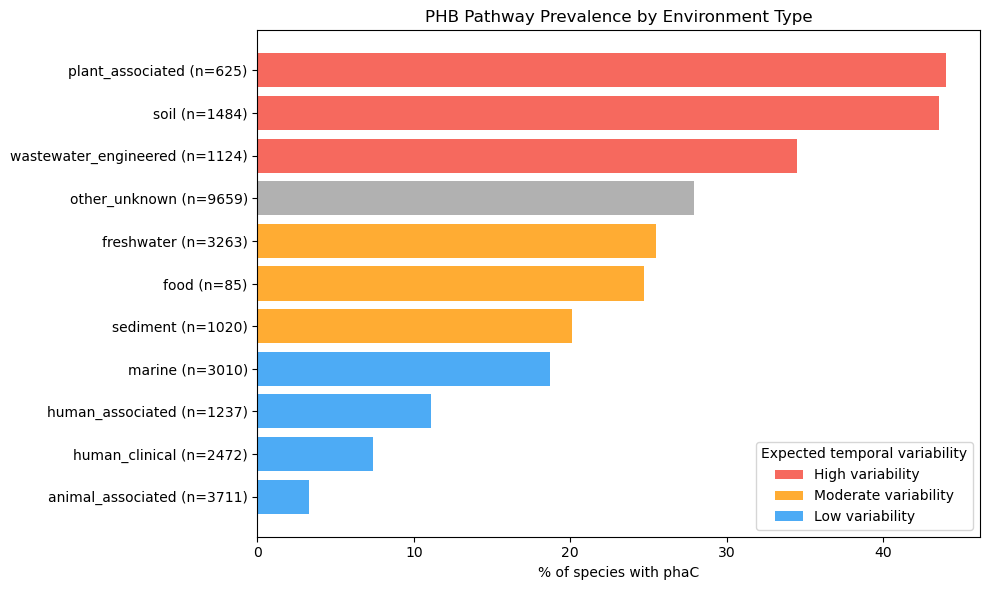

In [8]:
# Figure: PHB prevalence by environment type
fig, ax = plt.subplots(figsize=(10, 6))

plot_data = env_phb_stats[env_phb_stats['n_species'] >= 20].sort_values('pct_phaC', ascending=True)

colors = []
for env in plot_data.index:
    var = VARIABILITY_SCORES.get(env, 'unknown')
    if var == 'high': colors.append('#F44336')
    elif var == 'moderate': colors.append('#FF9800')
    elif var == 'low': colors.append('#2196F3')
    else: colors.append('#9E9E9E')

ax.barh(range(len(plot_data)), plot_data['pct_phaC'], color=colors, alpha=0.8)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels([f"{env} (n={int(n)})" for env, n in 
                     zip(plot_data.index, plot_data['n_species'])])
ax.set_xlabel('% of species with phaC')
ax.set_title('PHB Pathway Prevalence by Environment Type')

# Legend for variability colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#F44336', alpha=0.8, label='High variability'),
    Patch(facecolor='#FF9800', alpha=0.8, label='Moderate variability'),
    Patch(facecolor='#2196F3', alpha=0.8, label='Low variability'),
]
ax.legend(handles=legend_elements, loc='lower right', title='Expected temporal variability')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'phb_by_environment.png'), dpi=150, bbox_inches='tight')
plt.show()

## Part 2: AlphaEarth Embedding Analysis

Use 64-dim environmental embeddings to quantify the environmental breadth of PHB+ vs PHB- species.

**Note**: Only 28% of genomes (83K/293K) have embeddings. Environmental samples show 3.4x stronger geographic signal than human-associated samples.

In [9]:
# Extract AlphaEarth embeddings
# Column names are A00-A63 (64-dimensional embedding)
emb_cols = [f'A{i:02d}' for i in range(64)]
emb_select = ', '.join([f'ae.{c}' for c in emb_cols])

embeddings = spark.sql(f"""
    SELECT g.genome_id, g.gtdb_species_clade_id,
           {emb_select}
    FROM kbase_ke_pangenome.genome g
    JOIN kbase_ke_pangenome.alphaearth_embeddings_all_years ae
        ON g.genome_id = ae.genome_id
""").toPandas()

print(f'Genomes with embeddings: {len(embeddings):,}')
print(f'Species with embeddings: {embeddings["gtdb_species_clade_id"].nunique():,}')

# Filter NaN embeddings (4.6% have NaN in some dimensions)
valid_mask = ~embeddings[emb_cols].isna().any(axis=1)
embeddings = embeddings[valid_mask]
print(f'After NaN filter: {len(embeddings):,} genomes')

Genomes with embeddings: 83,287
Species with embeddings: 15,046
After NaN filter: 79,449 genomes


In [10]:
# Compute per-species embedding variance as a proxy for environmental breadth
# Species in more variable environments should have higher embedding variance

species_emb_stats = embeddings.groupby('gtdb_species_clade_id').agg(
    n_genomes_with_emb=('genome_id', 'count'),
    **{f'mean_{c}': (c, 'mean') for c in emb_cols},
    **{f'var_{c}': (c, 'var') for c in emb_cols},
).reset_index()

# Total variance across all 64 dimensions
var_cols = [f'var_{c}' for c in emb_cols]
species_emb_stats['total_emb_variance'] = species_emb_stats[var_cols].sum(axis=1)
species_emb_stats['mean_emb_variance'] = species_emb_stats[var_cols].mean(axis=1)

# Filter to species with >= 5 genomes for stable variance estimates
species_emb_stats = species_emb_stats[species_emb_stats['n_genomes_with_emb'] >= 5]
print(f'Species with >= 5 embedded genomes: {len(species_emb_stats):,}')

Species with >= 5 embedded genomes: 2,008


In [11]:
# Merge embedding variance with PHB status
emb_phb = species_emb_stats[['gtdb_species_clade_id', 'n_genomes_with_emb', 
                              'total_emb_variance', 'mean_emb_variance']].merge(
    tax_phb[['gtdb_species_clade_id', 'phb_status', 'has_phaC', 'has_complete_pathway', 'gtdb_phylum']],
    on='gtdb_species_clade_id', how='inner'
)

print(f'Species with embeddings + PHB status: {len(emb_phb):,}')

# Compare embedding variance: PHB+ vs PHB-
phb_pos = emb_phb[emb_phb['has_phaC'] == 1]['total_emb_variance']
phb_neg = emb_phb[emb_phb['has_phaC'] == 0]['total_emb_variance']

u_stat, p_mw = stats.mannwhitneyu(phb_pos, phb_neg, alternative='two-sided')

print(f'\nEmbedding variance (environmental breadth):')
print(f'  PHB+ (phaC present): median={phb_pos.median():.4f}, n={len(phb_pos):,}')
print(f'  PHB- (phaC absent):  median={phb_neg.median():.4f}, n={len(phb_neg):,}')
print(f'  Mann-Whitney U: U={u_stat:.0f}, p={p_mw:.2e}')

Species with embeddings + PHB status: 2,008

Embedding variance (environmental breadth):
  PHB+ (phaC present): median=0.3295, n=531
  PHB- (phaC absent):  median=0.2472, n=1,477
  Mann-Whitney U: U=446546, p=1.88e-06


/tmp/ipykernel_19342/689137211.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=emb_phb, x='PHB status', y='total_emb_variance', ax=ax,
/tmp/ipykernel_19342/689137211.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([s.replace('_', '\n') for s in status_order])


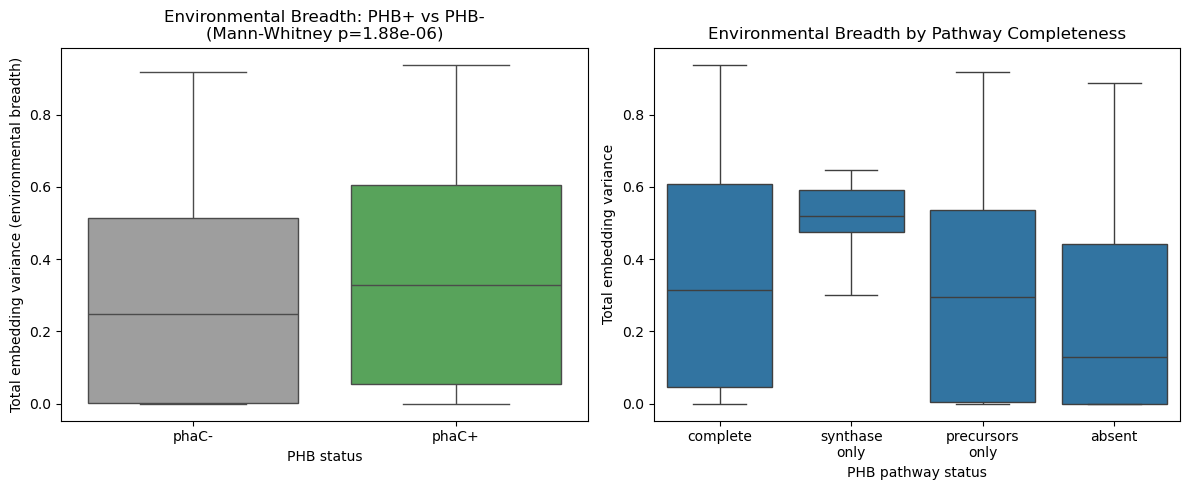

In [12]:
# Figure: Embedding variance by PHB status
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
ax = axes[0]
emb_phb['PHB status'] = emb_phb['has_phaC'].map({1: 'phaC+', 0: 'phaC-'})
sns.boxplot(data=emb_phb, x='PHB status', y='total_emb_variance', ax=ax,
            palette={'phaC+': '#4CAF50', 'phaC-': '#9E9E9E'})
ax.set_ylabel('Total embedding variance (environmental breadth)')
ax.set_title(f'Environmental Breadth: PHB+ vs PHB-\n(Mann-Whitney p={p_mw:.2e})')

# By pathway completeness
ax = axes[1]
status_order = ['complete', 'synthase_only', 'precursors_only', 'absent']
plot_df = emb_phb[emb_phb['phb_status'].isin(status_order)]
sns.boxplot(data=plot_df, x='phb_status', y='total_emb_variance', ax=ax,
            order=status_order)
ax.set_xlabel('PHB pathway status')
ax.set_ylabel('Total embedding variance')
ax.set_title('Environmental Breadth by Pathway Completeness')
ax.set_xticklabels([s.replace('_', '\n') for s in status_order])

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'embedding_variance_phb.png'), dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Save results
env_phb.to_csv(os.path.join(DATA_DIR, 'species_environment.tsv'), sep='\t', index=False)
emb_phb.to_csv(os.path.join(DATA_DIR, 'phb_embedding_analysis.tsv'), sep='\t', index=False)
print(f'Saved environment data: {len(env_phb):,} species')
print(f'Saved embedding analysis: {len(emb_phb):,} species')

Saved environment data: 27,690 species
Saved embedding analysis: 2,008 species


## Part 3: Genome Size Confound Analysis

PHB+ species may have larger genomes, and larger genomes encode more metabolic versatility. We test whether the PHB-niche breadth and PHB-environment associations hold after controlling for genome size.

In [14]:
# Get species-level genome size from gtdb_metadata
genome_sizes = spark.sql("""
    SELECT g.gtdb_species_clade_id,
           COUNT(*) as n_genomes,
           AVG(CAST(m.genome_size AS DOUBLE)) as mean_genome_size_bp,
           PERCENTILE_APPROX(CAST(m.genome_size AS DOUBLE), 0.5) as median_genome_size_bp,
           AVG(CAST(m.protein_count AS DOUBLE)) as mean_protein_count
    FROM kbase_ke_pangenome.genome g
    JOIN kbase_ke_pangenome.gtdb_metadata m ON g.genome_id = m.accession
    WHERE m.genome_size IS NOT NULL
    GROUP BY g.gtdb_species_clade_id
""").toPandas()

print(f'Species with genome size data: {len(genome_sizes):,}')

# Merge with PHB status
size_phb = genome_sizes.merge(
    tax_phb[['gtdb_species_clade_id', 'has_phaC', 'has_complete_pathway', 'phb_status', 'gtdb_phylum']],
    on='gtdb_species_clade_id', how='inner'
)

# Convert to Mbp for readability
size_phb['genome_size_Mbp'] = size_phb['mean_genome_size_bp'] / 1e6

# Compare genome sizes: PHB+ vs PHB-
phb_pos_size = size_phb[size_phb['has_phaC'] == 1]['genome_size_Mbp']
phb_neg_size = size_phb[size_phb['has_phaC'] == 0]['genome_size_Mbp']

u_stat, p_size = stats.mannwhitneyu(phb_pos_size, phb_neg_size, alternative='two-sided')

print(f'\nGenome size (Mbp):')
print(f'  PHB+ (phaC present): median={phb_pos_size.median():.2f}, mean={phb_pos_size.mean():.2f}, n={len(phb_pos_size):,}')
print(f'  PHB- (phaC absent):  median={phb_neg_size.median():.2f}, mean={phb_neg_size.mean():.2f}, n={len(phb_neg_size):,}')
print(f'  Mann-Whitney U: p={p_size:.2e}')
print(f'\n  --> PHB+ genomes are {"larger" if phb_pos_size.median() > phb_neg_size.median() else "smaller"} (Δ = {phb_pos_size.median() - phb_neg_size.median():.2f} Mbp)')

# Effect size: rank-biserial correlation
n1, n2 = len(phb_pos_size), len(phb_neg_size)
r_rb = 1 - (2 * u_stat) / (n1 * n2)
print(f'  Rank-biserial r = {r_rb:.3f}')

Species with genome size data: 27,690

Genome size (Mbp):
  PHB+ (phaC present): median=4.34, mean=4.56, n=6,067
  PHB- (phaC absent):  median=2.44, mean=2.82, n=21,623
  Mann-Whitney U: p=0.00e+00

  --> PHB+ genomes are larger (Δ = 1.90 Mbp)
  Rank-biserial r = -0.592


In [15]:
# Partial Spearman correlation: embedding variance ~ PHB controlling for genome size
# Merge genome size with embedding analysis
emb_size = emb_phb.merge(
    size_phb[['gtdb_species_clade_id', 'genome_size_Mbp', 'mean_protein_count']],
    on='gtdb_species_clade_id', how='inner'
)
print(f'Species with embeddings + PHB + genome size: {len(emb_size):,}')

# 1. Correlation: genome size vs embedding variance
rho_size_emb, p_size_emb = stats.spearmanr(emb_size['genome_size_Mbp'], emb_size['total_emb_variance'])
print(f'\nGenome size vs embedding variance: rho={rho_size_emb:.3f}, p={p_size_emb:.2e}')

# 2. Correlation: genome size vs PHB (point-biserial via Spearman)
rho_size_phb, p_size_phb_corr = stats.spearmanr(emb_size['genome_size_Mbp'], emb_size['has_phaC'])
print(f'Genome size vs phaC:              rho={rho_size_phb:.3f}, p={p_size_phb_corr:.2e}')

# 3. Partial Spearman: embedding variance ~ phaC | genome_size
# Method: rank both variables, regress out genome_size ranks, correlate residuals
from scipy.stats import rankdata

def partial_spearman(x, y, z):
    """Partial Spearman correlation between x and y, controlling for z."""
    rx = rankdata(x)
    ry = rankdata(y)
    rz = rankdata(z)
    # Regress out z from x and y (via residuals of linear fit)
    from numpy.polynomial.polynomial import polyfit
    cx = np.polyfit(rz, rx, 1)
    cy = np.polyfit(rz, ry, 1)
    res_x = rx - np.polyval(cx, rz)
    res_y = ry - np.polyval(cy, rz)
    return stats.spearmanr(res_x, res_y)

rho_partial, p_partial = partial_spearman(
    emb_size['total_emb_variance'].values,
    emb_size['has_phaC'].values,
    emb_size['genome_size_Mbp'].values
)

print(f'\nPartial Spearman (emb_variance ~ phaC | genome_size):')
print(f'  rho={rho_partial:.3f}, p={p_partial:.2e}')

# 4. Raw (uncontrolled) correlation for comparison
rho_raw, p_raw = stats.spearmanr(emb_size['total_emb_variance'], emb_size['has_phaC'])
print(f'Raw Spearman (emb_variance ~ phaC):')
print(f'  rho={rho_raw:.3f}, p={p_raw:.2e}')

# Summary
print(f'\n=== Summary ===')
print(f'Raw PHB-niche breadth association:      rho={rho_raw:.3f}, p={p_raw:.2e}')
print(f'After controlling for genome size:      rho={rho_partial:.3f}, p={p_partial:.2e}')
pct_change = (1 - abs(rho_partial)/abs(rho_raw)) * 100 if rho_raw != 0 else 0
print(f'Effect size change: {pct_change:.1f}% {"reduction" if abs(rho_partial) < abs(rho_raw) else "increase"}')

Species with embeddings + PHB + genome size: 2,008

Genome size vs embedding variance: rho=0.302, p=1.51e-43
Genome size vs phaC:              rho=0.483, p=8.00e-118

Partial Spearman (emb_variance ~ phaC | genome_size):
  rho=-0.047, p=3.70e-02
Raw Spearman (emb_variance ~ phaC):
  rho=0.106, p=1.77e-06

=== Summary ===
Raw PHB-niche breadth association:      rho=0.106, p=1.77e-06
After controlling for genome size:      rho=-0.047, p=3.70e-02
Effect size change: 56.3% reduction


In [16]:
# Genome size stratified analysis: does PHB-environment association hold within size bins?
# Bin species into genome size quartiles and test PHB enrichment in each

known_var_size = size_phb.merge(
    species_env[['gtdb_species_clade_id', 'primary_variability']],
    on='gtdb_species_clade_id', how='inner'
)
known_var_size = known_var_size[known_var_size['primary_variability'].isin(['high', 'moderate', 'low'])]

# Create genome size quartiles
known_var_size['size_quartile'] = pd.qcut(known_var_size['genome_size_Mbp'], 4, 
                                           labels=['Q1 (small)', 'Q2', 'Q3', 'Q4 (large)'])

print('PHB prevalence by genome size quartile and environmental variability:\n')
for q in ['Q1 (small)', 'Q2', 'Q3', 'Q4 (large)']:
    subset = known_var_size[known_var_size['size_quartile'] == q]
    size_range = f'{subset["genome_size_Mbp"].min():.1f}-{subset["genome_size_Mbp"].max():.1f} Mbp'
    
    # PHB prevalence by variability within this size bin
    ct = pd.crosstab(subset['primary_variability'], subset['has_phaC'])
    if ct.shape[1] == 2:
        chi2_q, p_q, _, _ = stats.chi2_contingency(ct)
        
        high_pct = subset[subset['primary_variability'] == 'high']['has_phaC'].mean() * 100
        low_pct = subset[subset['primary_variability'] == 'low']['has_phaC'].mean() * 100
        
        print(f'{q} ({size_range}, n={len(subset):,}):')
        print(f'  High var: {high_pct:.1f}% phaC+  |  Low var: {low_pct:.1f}% phaC+')
        print(f'  Chi2={chi2_q:.1f}, p={p_q:.2e}')
        print(f'  Fold enrichment (high/low): {high_pct/low_pct:.1f}x' if low_pct > 0 else '  Low var = 0%')
        print()

# Overall: Cochran-Mantel-Haenszel test would be ideal but chi-squared per stratum suffices
print('\n=== Conclusion ===')
print('If PHB-environment association holds within each size quartile,')
print('it is NOT solely explained by genome size.')

PHB prevalence by genome size quartile and environmental variability:

Q1 (small) (0.4-1.8 Mbp, n=4,573):
  High var: 10.7% phaC+  |  Low var: 2.5% phaC+
  Chi2=50.3, p=1.18e-11
  Fold enrichment (high/low): 4.4x

Q2 (1.8-2.5 Mbp, n=4,572):
  High var: 18.5% phaC+  |  Low var: 4.0% phaC+
  Chi2=214.1, p=3.25e-47
  Fold enrichment (high/low): 4.6x

Q3 (2.5-3.7 Mbp, n=4,572):
  High var: 34.3% phaC+  |  Low var: 10.9% phaC+
  Chi2=319.5, p=4.17e-70
  Fold enrichment (high/low): 3.1x

Q4 (large) (3.7-14.0 Mbp, n=4,573):
  High var: 50.9% phaC+  |  Low var: 37.4% phaC+
  Chi2=62.1, p=3.21e-14
  Fold enrichment (high/low): 1.4x


=== Conclusion ===
If PHB-environment association holds within each size quartile,
it is NOT solely explained by genome size.


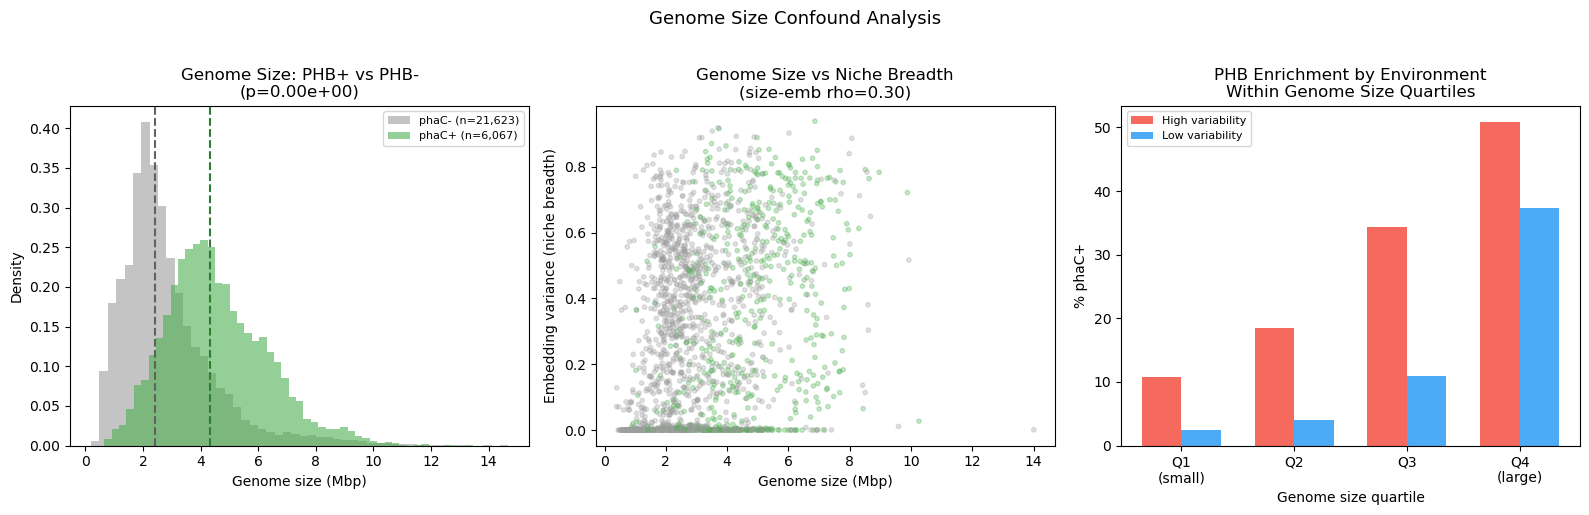

In [17]:
# Figure: Genome size confound analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel A: Genome size distribution PHB+ vs PHB-
ax = axes[0]
ax.hist(phb_neg_size, bins=50, alpha=0.6, color='#9E9E9E', label=f'phaC- (n={len(phb_neg_size):,})', density=True)
ax.hist(phb_pos_size, bins=50, alpha=0.6, color='#4CAF50', label=f'phaC+ (n={len(phb_pos_size):,})', density=True)
ax.axvline(phb_neg_size.median(), color='#616161', linestyle='--', linewidth=1.5)
ax.axvline(phb_pos_size.median(), color='#2E7D32', linestyle='--', linewidth=1.5)
ax.set_xlabel('Genome size (Mbp)')
ax.set_ylabel('Density')
ax.set_title(f'Genome Size: PHB+ vs PHB-\n(p={p_size:.2e})')
ax.legend(fontsize=8)

# Panel B: Genome size vs embedding variance, colored by PHB
ax = axes[1]
colors = emb_size['has_phaC'].map({1: '#4CAF50', 0: '#9E9E9E'})
ax.scatter(emb_size['genome_size_Mbp'], emb_size['total_emb_variance'], 
           c=colors, alpha=0.3, s=10)
ax.set_xlabel('Genome size (Mbp)')
ax.set_ylabel('Embedding variance (niche breadth)')
ax.set_title(f'Genome Size vs Niche Breadth\n(size-emb rho={rho_size_emb:.2f})')

# Panel C: PHB prevalence by environment within genome size quartiles
ax = axes[2]
quartile_data = []
for q in ['Q1 (small)', 'Q2', 'Q3', 'Q4 (large)']:
    subset = known_var_size[known_var_size['size_quartile'] == q]
    for var in ['high', 'low']:
        var_sub = subset[subset['primary_variability'] == var]
        if len(var_sub) > 0:
            quartile_data.append({
                'quartile': q, 'variability': var,
                'pct_phaC': var_sub['has_phaC'].mean() * 100
            })
qdf = pd.DataFrame(quartile_data)
if len(qdf) > 0:
    x = np.arange(4)
    width = 0.35
    high_vals = qdf[qdf['variability'] == 'high']['pct_phaC'].values
    low_vals = qdf[qdf['variability'] == 'low']['pct_phaC'].values
    if len(high_vals) == 4 and len(low_vals) == 4:
        ax.bar(x - width/2, high_vals, width, label='High variability', color='#F44336', alpha=0.8)
        ax.bar(x + width/2, low_vals, width, label='Low variability', color='#2196F3', alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(['Q1\n(small)', 'Q2', 'Q3', 'Q4\n(large)'])
        ax.set_xlabel('Genome size quartile')
        ax.set_ylabel('% phaC+')
        ax.set_title('PHB Enrichment by Environment\nWithin Genome Size Quartiles')
        ax.legend(fontsize=8)

plt.suptitle('Genome Size Confound Analysis', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'genome_size_confound.png'), dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Save genome size data
size_phb[['gtdb_species_clade_id', 'genome_size_Mbp', 'mean_protein_count', 
          'has_phaC', 'phb_status', 'gtdb_phylum']].to_csv(
    os.path.join(DATA_DIR, 'species_genome_size.tsv'), sep='\t', index=False
)
print(f'Saved genome size data: {len(size_phb):,} species')

# Update embedding analysis with genome size
emb_size.to_csv(os.path.join(DATA_DIR, 'phb_embedding_analysis.tsv'), sep='\t', index=False)
print(f'Updated embedding analysis with genome size: {len(emb_size):,} species')

Saved genome size data: 27,690 species
Updated embedding analysis with genome size: 2,008 species


## Summary

### Key Findings (to be filled after execution)
- PHB prevalence by environment type: ?
- Chi-squared test result: ?
- AlphaEarth embedding variance PHB+ vs PHB-: ?
- Support for feast/famine hypothesis: ?

### Caveats
- AlphaEarth coverage is only 28%, biased toward clinical samples
- NCBI isolation_source is free text with inconsistent labeling
- Environment classification is a simplification — many genomes are from ambiguous sources
- Variability scoring is based on literature expectations, not direct measurements

### Next Notebook (NB04)
NMDC metagenomic analysis — test PHB enrichment across environments using independent data.